In [1]:
#Long Short Term Neural Net using Python

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import keras
from ggplot import *
from matplotlib import pyplot

Using TensorFlow backend.
/Users/cmcnamara/anaconda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/cmcnamara/anaconda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/cmcnamara/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
features = pd.read_csv("~/Documents/Walmart Data/features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
features.shape

(8190, 12)

In [5]:
pre_train = pd.read_csv("~/Documents/Walmart Data/train 2.csv")
pre_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [6]:
pre_train.shape

(421570, 5)

In [7]:
stores = pd.read_csv("~/Documents/Walmart Data/stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
stores.shape

(45, 3)

In [9]:
true_train = pd.merge(pd.merge(pre_train, features, how = 'left',
                               left_on = ['Store', 'Date'], right_on = ['Store', 'Date']), 
                      stores, left_on = ['Store'], right_on = ['Store'])
true_train['Date'] = pd.to_datetime(true_train['Date'])
true_train = true_train.drop(['IsHoliday_y', 'Type'], 1)
true_train = true_train.fillna(true_train.median())
true_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,5347.45,192.0,24.6,1481.31,3359.45,211.096358,8.106,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,5347.45,192.0,24.6,1481.31,3359.45,211.242170,8.106,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,5347.45,192.0,24.6,1481.31,3359.45,211.289143,8.106,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,5347.45,192.0,24.6,1481.31,3359.45,211.319643,8.106,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,5347.45,192.0,24.6,1481.31,3359.45,211.350143,8.106,151315


In [10]:
true_train.shape

(421570, 15)

In [11]:
#Exploratory Analysis

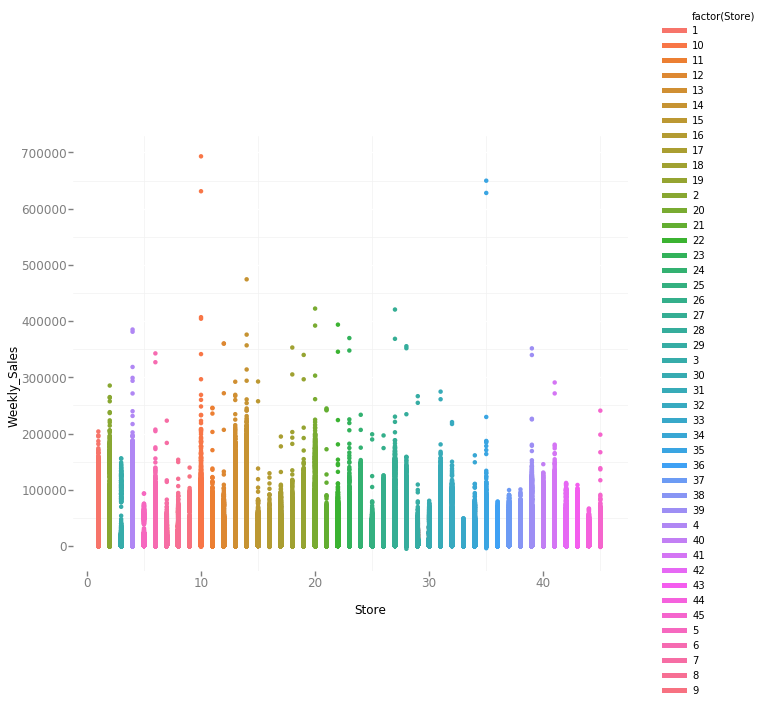

<ggplot: (298214755)>

In [12]:
ggplot(aes(x = 'Store', y = 'Weekly_Sales', color = 'factor(Store)'), true_train) + \
geom_point() +\
theme_bw()

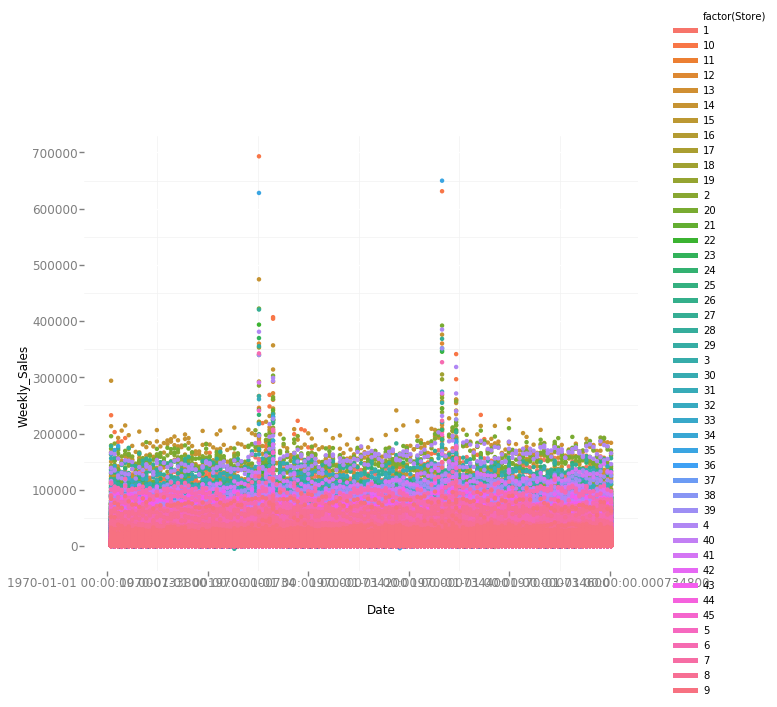

<ggplot: (-9223372036530440409)>

In [13]:
ggplot(aes(x = 'Date', y = 'Weekly_Sales', colour = 'factor(Store)'), true_train) + \
geom_point() +\
scale_x_date(format = '%b-%Y') +\
theme_bw()

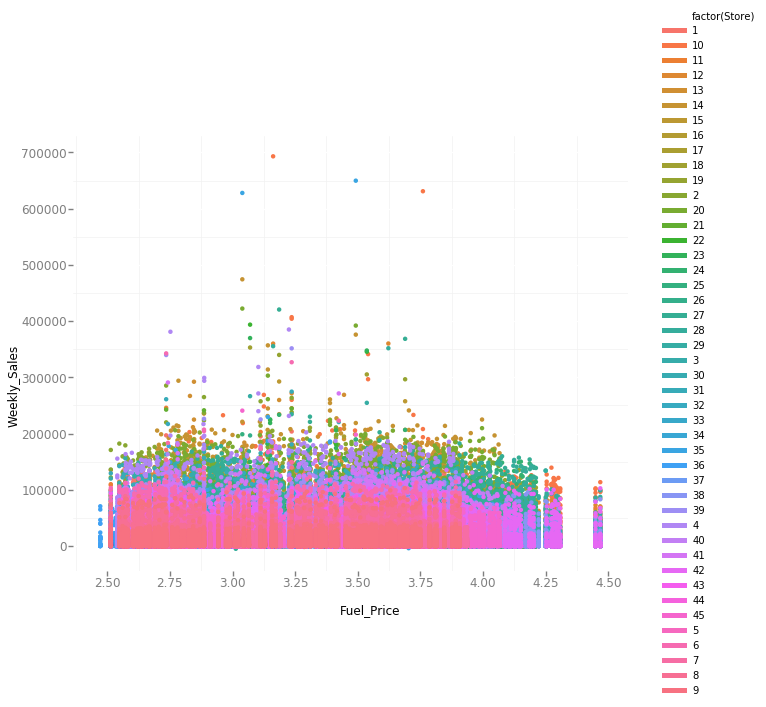

<ggplot: (-9223372036548198077)>

In [14]:
ggplot(aes('Fuel_Price', "Weekly_Sales", colour = 'factor(Store)'), true_train) + geom_point() +\
theme_bw()

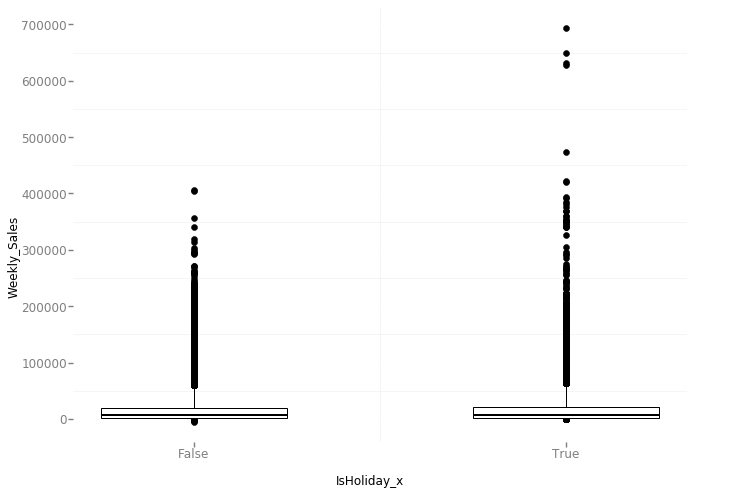

<ggplot: (-9223372036556560917)>

In [15]:
ggplot(aes('IsHoliday_x', "Weekly_Sales"), true_train) + geom_boxplot() +\
theme_bw()

In [16]:
#LTSM Neural Net

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

In [18]:
true_train['IsHoliday_x'] = true_train['IsHoliday_x'].astype(int) #Convert IsHolidayX to a boolean
true_train2 = true_train.sort_values('Date')
true_train2 = true_train2.set_index(true_train2['Date'])
true_train2 = true_train2.drop('Date',1)
true_train2.head()

,Store,Dept,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
Date,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,0,42.31,2.572,5347.45,192.0,24.6,1481.31,3359.45,211.096358,8.106,151315
2010-02-05,29,5,15552.08,0,24.36,2.788,5347.45,192.0,24.6,1481.31,3359.45,131.527903,10.064,93638
2010-02-05,29,6,3200.22,0,24.36,2.788,5347.45,192.0,24.6,1481.31,3359.45,131.527903,10.064,93638
2010-02-05,29,7,10820.05,0,24.36,2.788,5347.45,192.0,24.6,1481.31,3359.45,131.527903,10.064,93638
2010-02-05,29,8,20055.64,0,24.36,2.788,5347.45,192.0,24.6,1481.31,3359.45,131.527903,10.064,93638


In [21]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Returns a time series into a dataset applicable for supervised learning
    
    Arguments:
    data -- the timeseries data to be converted into supervised learning data
    n_in -- determines input sequence n. Default is n = 1
    n_out -- determines forecast sequence n. Default is n = 1
    dropnan -- True/False if the user wishes to eliminate all row values with a NaN in them. 
    Default is True.
    
    Returns:
    agg - the supervised learning dataset
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
#true_train2 = true_train2.drop('Weekly_Sales', 1)

msk = np.random.rand(len(true_train2)) < 0.8

train = true_train2[msk]
test = true_train2[~msk]
train_y = train['Weekly_Sales']
test_y = test['Weekly_Sales']
train = train.drop('Weekly_Sales',1)
test = test.drop('Weekly_Sales',1)

values = train.values

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

# reshape input to be 3D [samples, timesteps, features]
train_X = values.reshape((train.shape[0], 1, train.shape[1]))
#test_X = true_test2.reshape((true_test.shape[0], 1, true_test.shape[1]))

In [23]:
values = test.values

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

# reshape input to be 3D [samples, timesteps, features]
test_X = values.reshape((test.shape[0], 1, test.shape[1]))

In [24]:
model = Sequential()
#return_sequences = True allows us to build multi-layer NNs
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True))
model.add(LSTM(25))
#Dense determines how many outputs come from our NN
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 337066 samples, validate on 84504 samples
Epoch 1/50
62s - loss: 15940.2741 - val_loss: 15845.0466
Epoch 2/50
61s - loss: 15858.2603 - val_loss: 15766.5042
Epoch 3/50
60s - loss: 15781.3095 - val_loss: 15690.9122
Epoch 4/50
60s - loss: 15707.0348 - val_loss: 15617.8761
Epoch 5/50
65s - loss: 15635.1102 - val_loss: 15547.1573
Epoch 6/50
59s - loss: 15565.3132 - val_loss: 15478.4928
Epoch 7/50
60s - loss: 15497.4409 - val_loss: 15411.6410
Epoch 8/50
59s - loss: 15431.3577 - val_loss: 15346.5332
Epoch 9/50
61s - loss: 15366.9600 - val_loss: 15283.1176
Epoch 10/50
59s - loss: 15304.1487 - val_loss: 15221.2465
Epoch 11/50
61s - loss: 15242.8833 - val_loss: 15160.8210
Epoch 12/50
61s - loss: 15183.0541 - val_loss: 15101.8062
Epoch 13/50
60s - loss: 15124.6041 - val_loss: 15044.1360
Epoch 14/50
62s - loss: 15067.5245 - val_loss: 14987.7949
Epoch 15/50
60s - loss: 15011.7698 - val_loss: 14932.8343
Epoch 16/50
60s - loss: 14957.3430 - val_loss: 14879.1797
Epoch 17/50
60s - loss: 14904.

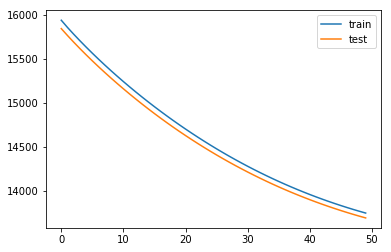

NameError: name 'concatenate' is not defined

In [25]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
#Setting Up WalMart Test Data for Predictions

In [ ]:
pre_test = pd.read_csv("~/Documents/Walmart Data/test 2.csv")
pre_test.head()

In [ ]:
pre_test.shape

In [ ]:
true_test = pd.merge(pd.merge(pre_test, features, how = 'left',
                              left_on = ['Store', 'Date'], right_on = ['Store', 'Date']),
                     stores, left_on = ['Store'], right_on = ['Store'])
true_test['Date'] = pd.to_datetime(true_test['Date'])
true_test = true_test.drop(['IsHoliday_y', 'Type'], 1)
true_test = true_test.fillna(true_test.median())
true_test.head()

In [ ]:
true_test.shape

In [ ]:
true_test['IsHoliday_x'] = true_test['IsHoliday_x'].astype(int)
true_test2 = true_test.sort_values('Date')
true_test2 = true_test2.set_index(true_test2['Date'])
true_test2 = true_test2.drop('Date',1)
true_test2.head()